# PRODUCT PROPENSITY - PROD - Redshift
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 21, 2022

## Hypothesis
Recently the stored procedure that pulls data for training and scoring the retention model was migrated to RedShift. We are asuming that the logic is still valid and that the data can be used with our existing retention model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

from pycaret.classification import *

In [2]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

CDWQ-FNSB
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [3]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'prod-app'
DBNAME = 'stlrmilb'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'prod-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: prod-app stlrmilb


In [4]:
# call the stored proc to get data for the retention model
cur = conn.cursor()
cur.execute(f"CALL dw.getproductpropensitymodeldata_all_teams(2010, 2022, 'temp_cursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('temp_cursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4973395 entries, 0 to 4973394
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   dimcustomermasterid  int64  
 1   distance             float64
 2   seasonyear           int64  
 3   events_prior         int64  
 4   attended_prior       int64  
 5   events_last          int64  
 6   attended_last        int64  
 7   tenure               int64  
 8   atp_last             float64
 9   product_current      object 
dtypes: float64(2), int64(7), object(1)
memory usage: 379.4+ MB


In [6]:
# choose the features for the stellar base retention model
features = [
    "dimcustomermasterid",
    "attendancepercent",
    "clicktoopenratio", 
    "clicktosendratio",
    "disttovenue",
    "inperson_contact",
    "isnextyear_buyer",
    "lkupclientid",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "opentosendratio",
    "productgrouping",
    "recency",
    "renewedbeforedays",
    "source_tenure",
    "totalspent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5182, 18)
Unseen Data For Predictions: (914, 18)



In [7]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimcustomermasterid",
        "lkupclientid",
        "productgrouping",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
        "disttovenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedbeforedays",
        "source_tenure",
        "totalspent"
    ]
);

In [8]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7725,0.7835,0.9080,0.8055,0.8536,0.3512,0.3644,0.2960


In [9]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7687,0.7825,0.8975,0.8073,0.8500,0.3512,0.3608
1,0.7937,0.7912,0.9255,0.8164,0.8675,0.4090,0.4260
2,0.7823,0.7839,0.9099,0.8139,0.8592,0.3857,0.3977
3,0.7982,0.8088,0.9068,0.8319,0.8678,0.4452,0.4527
4,0.7500,0.7812,0.8944,0.7912,0.8397,0.2822,0.2934
5,0.7455,0.7721,0.9068,0.7807,0.8391,0.2463,0.2629
6,0.7659,0.7444,0.8910,0.8079,0.8474,0.3501,0.3579
7,0.7955,0.8188,0.9346,0.8130,0.8696,0.4063,0.4284
8,0.7591,0.7563,0.9034,0.7945,0.8455,0.3091,0.3227
9,0.7659,0.7959,0.9097,0.7978,0.8501,0.3267,0.3418


In [10]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(1746, 23)

In [11]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,...,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer,Label,Score_0,Score_1
75,31,457938180,2022,Half Season,588.0,1970-01-01,1.00,46,1095,1096,...,0.49,0.02,0.05,Unknown,6,0,0,0,0.5417,0.4583
76,31,457985469,2022,Full Season,1730.0,1970-01-01,0.57,193,2920,3179,...,1.86,0.19,0.10,Female,5,0,0,1,0.0574,0.9426
77,31,457997185,2022,Full Season,900.0,1970-01-01,0.86,193,1460,1573,...,2.30,0.19,0.08,Female,10,0,0,1,0.1010,0.8990
78,31,457923995,2022,Half Season,486.0,1970-01-01,0.00,58,2190,999,...,1.33,0.00,0.00,Male,6,0,0,0,0.9415,0.0585
79,31,457930864,2022,Full Season,5400.0,1970-01-01,0.20,193,730,879,...,2.85,0.22,0.08,Female,6,0,0,1,0.2613,0.7387


In [12]:
new_predictions["Label"].value_counts()

1    1503
0     243
Name: Label, dtype: int64

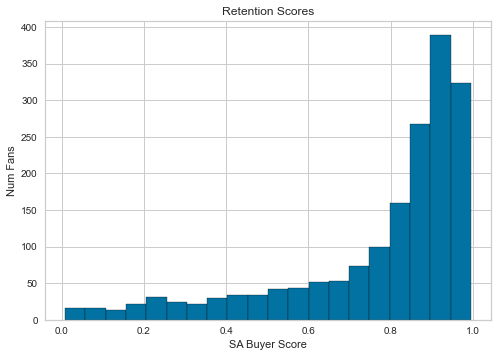

In [13]:
plt.hist(new_predictions["Score_1"], bins=20, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

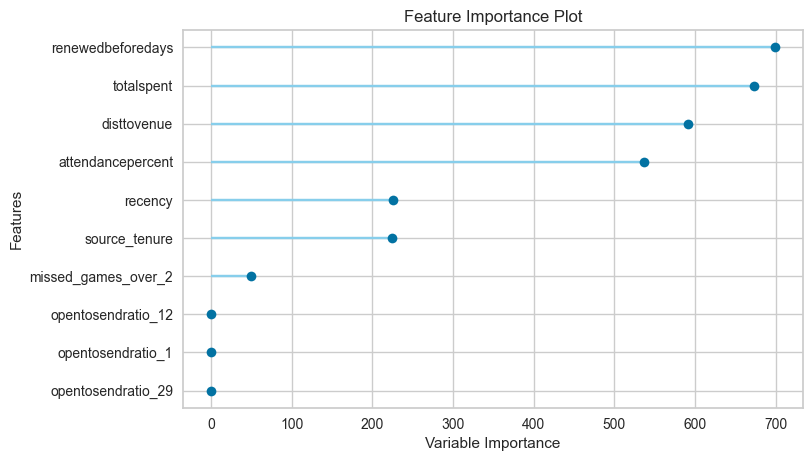

In [14]:
plot_model(final_model, plot='feature')

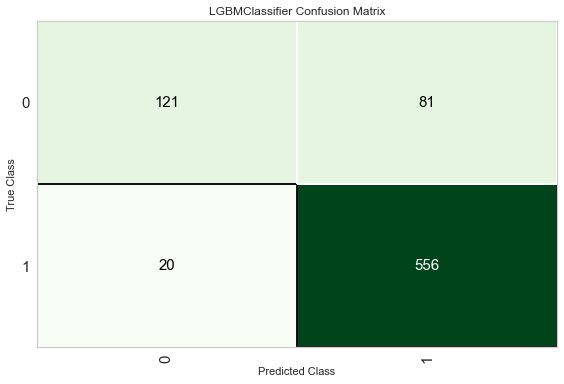

In [15]:
plot_model(final_model, plot='confusion_matrix')

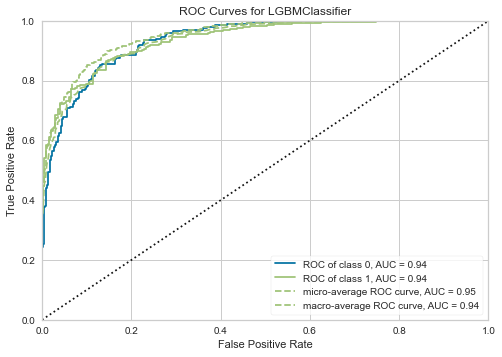

In [16]:
plot_model(final_model, plot='auc')

### Done